In [ ]:
# Helper Functions
import pandas as pd
import numpy as np

import json
import matplotlib.pylab as plt
import shapely
import matplotlib

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapely.ops as so

from shapely.affinity import scale
from shapely.ops import transform

import copy as copy
import gc

def split_col(df):
    df = pd.concat([
        df['site_path_timestamp'].str.split('_', expand=True) \
        .rename(columns={0:'site',
                         1:'path',
                         2:'timestamp'}),
        df
    ], axis=1).copy()
    return df

floor_map = {"B2":-2, "B1":-1, "F1":0, "F2": 1, "F3":2,
             "F4":3, "F5":4, "F6":5, "F7":6,"F8":7,"F9":8,
             "1F":0, "2F":1, "3F":2, "4F":3, "5F":4, "6F":5,
             "7F":6, "8F": 7, "9F":8}


def plot_preds(
    site,
    floorNo,
    sub=None,
    true_locs=None,
    base="../input/indoor-location-navigation",
    show_train=True,
    show_preds=True,
    fix_labels=True,
    map_floor=None
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    if map_floor is None:
        map_floor = floorNo
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)

    if show_train:
        true_locs = true_locs.query('site == @site and floorNo == @map_floor').copy()
        true_locs["x_"] = true_locs["x"] * floor_img.shape[0] / height_meter
        true_locs["y_"] = (
            true_locs["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        true_locs.query("site == @site and floorNo == @map_floor").groupby("path").plot(
            x="x_",
            y="y_",
            style="+",
            ax=ax,
            label="train waypoint location",
            color="grey",
            alpha=0.5,
        )

    if show_preds:
        sub = sub.query('site == @site and floorNo == @floorNo').copy()
        sub["x_"] = sub["x"] * floor_img.shape[0] / height_meter
        sub["y_"] = (
            sub["y"] * -1 * floor_img.shape[1] / width_meter
        ) + floor_img.shape[0]
        for path, path_data in sub.query(
            "site == @site and floorNo == @floorNo"
        ).groupby("path"):
            path_data.plot(
                x="x_",
                y="y_",
                style=".-",
                ax=ax,
                title=f"{site} - floor - {floorNo}",
                alpha=1,
                label=path,
            )
    if fix_labels:
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
        )
    return fig, ax

def sub_process(sub, train_waypoints):
    train_waypoints['isTrainWaypoint'] = True
    sub = split_col(sub[['site_path_timestamp','floor','x','y']]).copy()
    sub = sub.merge(train_waypoints[['site','floorNo','floor']].drop_duplicates(), how='left')
    sub = sub.merge(
        train_waypoints[['x','y','site','floor','isTrainWaypoint']].drop_duplicates(),
        how='left',
        on=['site','x','y','floor']
             )
    sub['isTrainWaypoint'] = sub['isTrainWaypoint'].fillna(False)
    return sub.copy()

import shapely as sh

def get_coords_from_polygon(shape):
    coords = set()

    if isinstance(shape, sh.geometry.Polygon):
        coords.update(shape.exterior.coords[:-1])
        for linearring in shape.interiors:
            coords.update(linearring.coords[:-1])
    elif isinstance(shape, sh.geometry.MultiPolygon):
        for polygon in shape:
            coords.update(get_coords_from_polygon(polygon))

    return coords

In [ ]:
train_waypoints = pd.read_csv('../input/indoor-location-train-waypoints/train_waypoints.csv')
train_waypoints['isTrainWaypoint'] = True

## Step 1: Identify training waypoints

In [ ]:
# Blend Subs
sub1 = split_col(pd.read_csv('../input/indoor-location-train-waypoints/6.771LB_submission.csv'))
sub2 = split_col(pd.read_csv('../input/indoor-location-train-waypoints/7.274LB_submission.csv'))
sub3 = split_col(pd.read_csv('../input/indoor-location-train-waypoints/7.518LB_submission_LSTM.csv'))
sub4 = split_col(pd.read_csv('../input/indoor-location-train-waypoints/7.661LB_LSTM_submission.csv'))
sub5 = split_col(pd.read_csv('../input/indoor-location-train-waypoints/7.745LB_submission.csv'))

# Blend
sub = sub1.merge(sub2[['site_path_timestamp','floor','x','y']],
           on=['site_path_timestamp','floor'],
           how='left',
           suffixes=('_s1','_s2')).copy()
sub['x'] = sub1['x'] 
sub['y'] = sub1['y'] 

sub = sub.merge(sub3[['site_path_timestamp','floor','x','y']],
           on=['site_path_timestamp','floor'],
           how='left',
           suffixes=('','_s3')).copy()
sub = sub.merge(sub4[['site_path_timestamp','floor','x','y']],
           on=['site_path_timestamp','floor'],
           how='left',
           suffixes=('','_s4')).copy()
sub = sub.merge(sub5[['site_path_timestamp','floor','x','y']],
           on=['site_path_timestamp','floor'],
           how='left',
           suffixes=('','_s5')).copy()

sub['x'] = sub[['x_s1','x_s2','x_s3','x_s4','x_s5']].mean(axis=1)
sub['y'] = sub[['y_s1','y_s2','y_s3','y_s4','y_s5']].mean(axis=1)

floors = np.unique(list(train_waypoints['floorNo']))
sites = np.unique(list(train_waypoints['site']))

For example, let us choose the site and the floor:

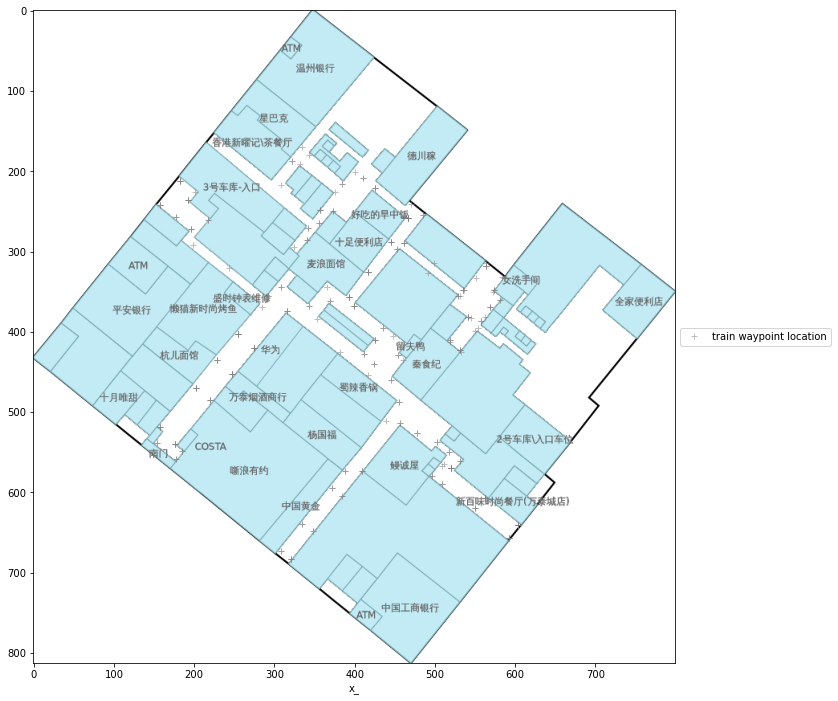

In [ ]:
train_waypoints = pd.read_csv('../input/indoor-location-train-waypoints/train_waypoints.csv')
train_waypoints['isTrainWaypoint'] = True
# sub = sub_process(pd.read_csv('../input/indoor-location-train-waypoints/6.578LB_submission.csv'),
#                  train_waypoints)
sub = sub_process(sub, train_waypoints)
# Plot the training Data For an example Floor
#Here we choose the site and the floor for the example
example_site = sites[15]
example_floorNo = floors[11]

plot_preds(example_site, example_floorNo, sub,
           train_waypoints, show_preds=False)
plt.show()

Lets get the polygons:

In [ ]:
with open(f"../input/indoor-location-navigation/metadata/{sites[15]}/{floors[11]}/geojson_map.json") as json_file:
    
    geofloor_data = json.load(json_file)

type_poly = geofloor_data['features'][0]['geometry']['type']

if type_poly == 'Polygon':
    
    polygon = np.array(geofloor_data['features'][0]['geometry']['coordinates'][0])

else:
    
    polygon = np.array(geofloor_data['features'][0]['geometry']['coordinates'][0][0])

floor_polygons = Polygon(polygon)

store_polygons_l = [Polygon(features['geometry']['coordinates'][0]) for features in geofloor_data['features'][1:]]

store_polygons = so.unary_union(store_polygons_l)

safe_area_polygons = floor_polygons.difference(store_polygons)

In [ ]:
#get the centers of the polygons
x_mean = (polygon[:, 0].max() - polygon[:, 0].min())*0.5 + polygon[:, 0].min()
y_mean = (polygon[:, 1].max() - polygon[:, 1].min())*0.5 + polygon[:, 1].min()

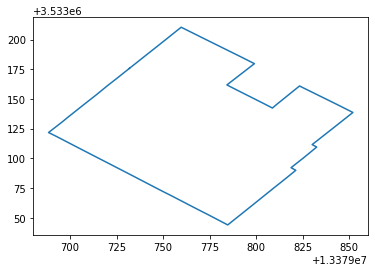

In [ ]:
x,y = floor_polygons.exterior.xy
plt.plot(x,y)

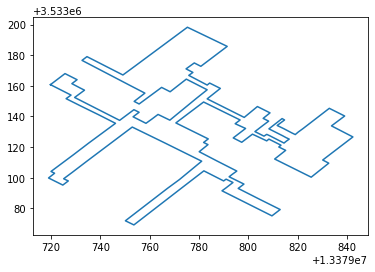

In [ ]:
x,y = safe_area_polygons[0].exterior.xy
plt.plot(x,y)

For some reason grid generator code below tends to mirror the polygons, so we are going to mirror them in advance to get the normal ones
for the processing

In [ ]:
floor_polygons1 = scale(floor_polygons, xfact = -1, origin = (x_mean, y_mean))
floor_polygons1 = scale(floor_polygons1, yfact = -1, origin = (x_mean, y_mean))

safe_area_polygons1 = scale(safe_area_polygons, xfact = -1, origin = (x_mean, y_mean))
safe_area_polygons1 = scale(safe_area_polygons1, yfact = -1, origin = (x_mean, y_mean))

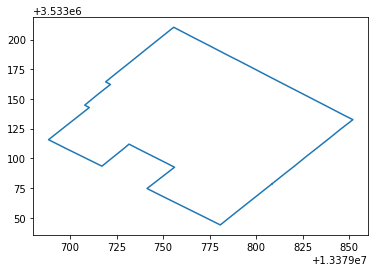

In [ ]:
x,y = floor_polygons1.exterior.xy
plt.plot(x,y)

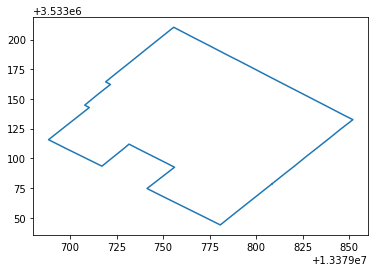

In [ ]:
x,y = floor_polygons1.exterior.xy
plt.plot(x,y)

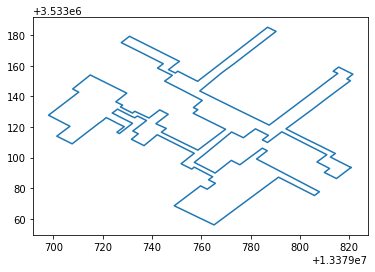

In [ ]:
x,y = safe_area_polygons1[0].exterior.xy
plt.plot(x,y)

In [ ]:
xy_comb = train_waypoints[['site', 'floorNo']].values
xy_comb_unique = [list(x) for x in set(tuple(x) for x in xy_comb)]

In [ ]:
len(xy_comb_unique)

139

In [ ]:
train_waypoints = pd.read_csv('../input/indoor-location-train-waypoints/train_waypoints.csv')
train_waypoints['isTrainWaypoint'] = True

In [ ]:
#distance between points on the grid
dense_step = 3.0

In [ ]:
for j in range(0, len(sites)):
    
    print(f'site is number {j} out of a {len(sites)}')
    
    for i in range(0, len(floors)):
        
        print(f'floor is number {i} out of a {len(floors)}')
        
        site = sites[j]
        floorNo = floors[i]
        
        if [sites[j], floors[i]] in xy_comb_unique:
            
            print('now we count')
            
    
            with open(f"../input/indoor-location-navigation/metadata/{site}/{floorNo}/floor_info.json") as json_file0:

                json_data = json.load(json_file0)
                
            width_meter = json_data["map_info"]["width"]
            height_meter = json_data["map_info"]["height"]
        
            with open(f"../input/indoor-location-navigation/metadata/{site}/{floorNo}/geojson_map.json") as json_file:

                geofloor_data = json.load(json_file)

            type_poly = geofloor_data['features'][0]['geometry']['type']

            if type_poly == 'Polygon':

                polygon = np.array(geofloor_data['features'][0]['geometry']['coordinates'][0])

            else:

                polygon = np.array(geofloor_data['features'][0]['geometry']['coordinates'][0][0])

            floor_polygons = Polygon(polygon)

            store_polygons_l = [Polygon(features['geometry']['coordinates'][0]) for features in geofloor_data['features'][1:]]

            store_polygons = so.unary_union(store_polygons_l)

            safe_area_polygons = floor_polygons.difference(store_polygons)

            x_max = polygon[:, 0].max()
            y_max = polygon[:, 1].max()
            
            y_min = polygon[:,1].min()
            x_min = polygon[:,0].min()
            
            x_mean = (polygon[:, 0].max() - polygon[:, 0].min())*0.5 + polygon[:, 0].min()
            y_mean = (polygon[:, 1].max() - polygon[:, 1].min())*0.5 + polygon[:, 1].min()
            
            floor_polygons = scale(floor_polygons, xfact = -1, origin = (x_mean, y_mean))
            floor_polygons = scale(floor_polygons, yfact = -1, origin = (x_mean, y_mean))

            safe_area_polygons = scale(safe_area_polygons, xfact = -1, origin = (x_mean, y_mean))
            safe_area_polygons = scale(safe_area_polygons, yfact = -1, origin = (x_mean, y_mean))

            temp_df = train_waypoints.loc[(train_waypoints['site'] == sites[j]) & (train_waypoints['floorNo'] == floors[i])]

            min_x = np.min(temp_df['x'])
            max_x = np.max(temp_df['x'])

            min_y = np.min(temp_df['y'])
            max_y = np.max(temp_df['y'])

            min_x_moving = copy.copy(min_x)
            min_y_moving = copy.copy(min_y)

            max_x_moving = copy.copy(max_x)
            max_y_moving = copy.copy(max_y)

            y_values = [min_y_moving]
            x_values = [min_x_moving]

            while min_x_moving <= max_x_moving:

                min_x_moving = min_x_moving + dense_step
                x_values.append(min_x_moving)

            x_values.append(max_x_moving)

            while min_y_moving <= max_y_moving:

                min_y_moving = min_y_moving + dense_step
                y_values.append(min_y_moving)

            y_values.append(max_y_moving)

            for x_iter in range(0, len(x_values)):

                for y_iter in range(0, len(y_values)):

                    x_scaled = x_max - x_values[x_iter]*(x_max - x_min)/width_meter
                    y_scaled = y_max - y_values[y_iter]*(y_max - y_min)/height_meter
                    
                    InSafe = safe_area_polygons.contains(Point(x_scaled, y_scaled))

                    if InSafe == True:

                        df2 = pd.DataFrame([['TYPE_WAYPOINT', x_values[x_iter],  y_values[y_iter], 1573187328401, site, floorNo, 666, 
                                            '5dc4f878171e610006b5d8ad', True]],
                                           columns=['type_name','x','y', 'timestamp', 'site', 'floorNo', 'floor', 'path', 'isTrainWaypoint'])

                        train_waypoints = pd.concat([df2, train_waypoints]).reset_index(drop=True)            

site is number 0 out of a 24
floor is number 0 out of a 19
floor is number 1 out of a 19
floor is number 2 out of a 19
floor is number 3 out of a 19
floor is number 4 out of a 19
floor is number 5 out of a 19
floor is number 6 out of a 19
floor is number 7 out of a 19
floor is number 8 out of a 19
floor is number 9 out of a 19
now we count
floor is number 10 out of a 19
floor is number 11 out of a 19
now we count
floor is number 12 out of a 19
now we count
floor is number 13 out of a 19
now we count
floor is number 14 out of a 19
now we count
floor is number 15 out of a 19
floor is number 16 out of a 19
floor is number 17 out of a 19
floor is number 18 out of a 19
site is number 1 out of a 24
floor is number 0 out of a 19
floor is number 1 out of a 19
floor is number 2 out of a 19
floor is number 3 out of a 19
floor is number 4 out of a 19
floor is number 5 out of a 19
floor is number 6 out of a 19
floor is number 7 out of a 19
floor is number 8 out of a 19
floor is number 9 out of a 1

In [ ]:
train_waypoints.loc[(train_waypoints['site'] == sites[15]) & (train_waypoints['floorNo'] == floors[11])]

,type_name,x,y,timestamp,site,floorNo,floor,path,isTrainWaypoint
24867,TYPE_WAYPOINT,106.765680,77.022278,1573187328401,5da138364db8ce0c98bc00f1,F1,666,5dc4f878171e610006b5d8ad,True
24868,TYPE_WAYPOINT,106.765680,74.022278,1573187328401,5da138364db8ce0c98bc00f1,F1,666,5dc4f878171e610006b5d8ad,True
24869,TYPE_WAYPOINT,106.765680,68.022278,1573187328401,5da138364db8ce0c98bc00f1,F1,666,5dc4f878171e610006b5d8ad,True
24870,TYPE_WAYPOINT,106.765680,59.022278,1573187328401,5da138364db8ce0c98bc00f1,F1,666,5dc4f878171e610006b5d8ad,True
24871,TYPE_WAYPOINT,108.171469,80.022278,1573187328401,5da138364db8ce0c98bc00f1,F1,666,5dc4f878171e610006b5d8ad,True
...,...,...,...,...,...,...,...,...,...
100720,TYPE_WAYPOINT,93.648125,80.834880,1571729665162,5da138364db8ce0c98bc00f1,F1,0,5daebc55e415cd0006629383,True
100721,TYPE_WAYPOINT,95.790210,76.398590,1571729681278,5da138364db8ce0c98bc00f1,F1,0,5daebc55e415cd0006629383,True
100722,TYPE_WAYPOINT,91.725580,71.229576,1571729691572,5da138364db8ce0c98bc00f1,F1,0,5daebc55e415cd0006629383,True
100723,TYPE_WAYPOINT,84.509094,50.747482,1571727679083,5da138364db8ce0c98bc00f1,F1,0,5daeb006aa1d300006faaecc,True


In [ ]:
temp_df = train_waypoints.loc[(train_waypoints['site'] == sites[15]) & (train_waypoints['floorNo'] == floors[11]) & (train_waypoints['isTrainWaypoint'] == True) ]
temp_df_o = train_waypoints.loc[(train_waypoints['site'] == sites[15]) & (train_waypoints['floorNo'] == floors[11]) & (train_waypoints['floor'] != 666) ]

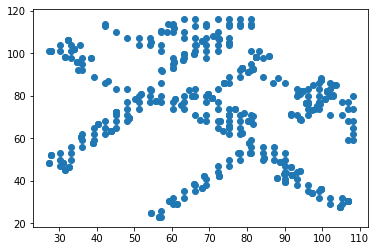

In [ ]:
temp_df
x = temp_df['x']
y = temp_df['y']
matplotlib.pyplot.scatter(x,y)

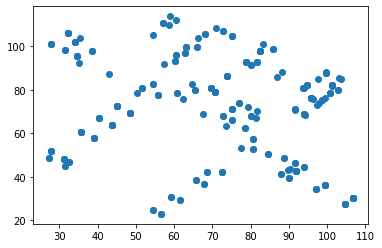

In [ ]:
x = temp_df_o['x']
y = temp_df_o['y']
matplotlib.pyplot.scatter(x,y)

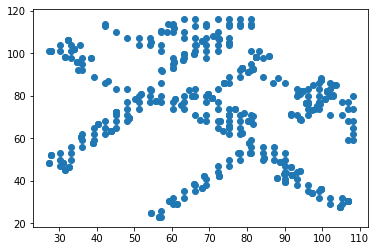

In [ ]:
temp_full = train_waypoints.loc[(train_waypoints['site'] == sites[15]) & (train_waypoints['floorNo'] == floors[11])]
x = temp_full['x']
y = temp_full['y']
matplotlib.pyplot.scatter(x,y)

Generated grid seems to match the original one, so let us go further

## Step 2: Find the closest "grid" point for each prediction.

We can find the closest "grid" point to our predictions using the `cdist` function in scipy.

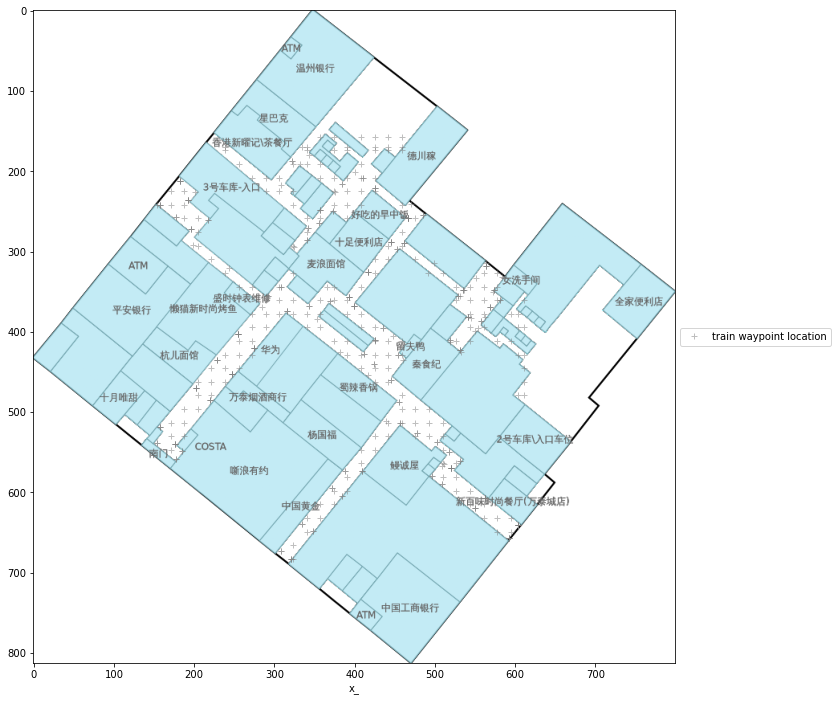

In [ ]:
#train_waypoints = pd.read_csv('../input/indoor-location-train-waypoints/train_waypoints.csv')
#train_waypoints['isTrainWaypoint'] = True
# sub = sub_process(pd.read_csv('../input/indoor-location-train-waypoints/6.578LB_submission.csv'),
#                  train_waypoints)
sub = sub_process(sub, train_waypoints)
# Plot the training Data For an example Floor
example_site = sites[15]
example_floorNo = floors[11]

plot_preds(example_site, example_floorNo, sub,
           train_waypoints, show_preds=False)
plt.show()

Looks dense enough

In [ ]:
from scipy.spatial.distance import cdist

def add_xy(df):
    df['xy'] = [(x, y) for x,y in zip(df['x'], df['y'])]
    return df

def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

sub = add_xy(sub)
train_waypoints = add_xy(train_waypoints)

ds = []
for (site, myfloor), d in sub.groupby(['site','floorNo']):
    true_floor_locs = train_waypoints.loc[(train_waypoints['floorNo'] == myfloor) &
                                          (train_waypoints['site'] == site)] \
        .reset_index(drop=True)
    if len(true_floor_locs) == 0:
        print(f'Skipping {site} {myfloor}')
        continue
    d['matched_point'] = [closest_point(x, list(true_floor_locs['xy'])) for x in d['xy']]
    d['x_'] = d['matched_point'].apply(lambda x: x[0])
    d['y_'] = d['matched_point'].apply(lambda x: x[1])
    ds.append(d)

sub = pd.concat(ds)

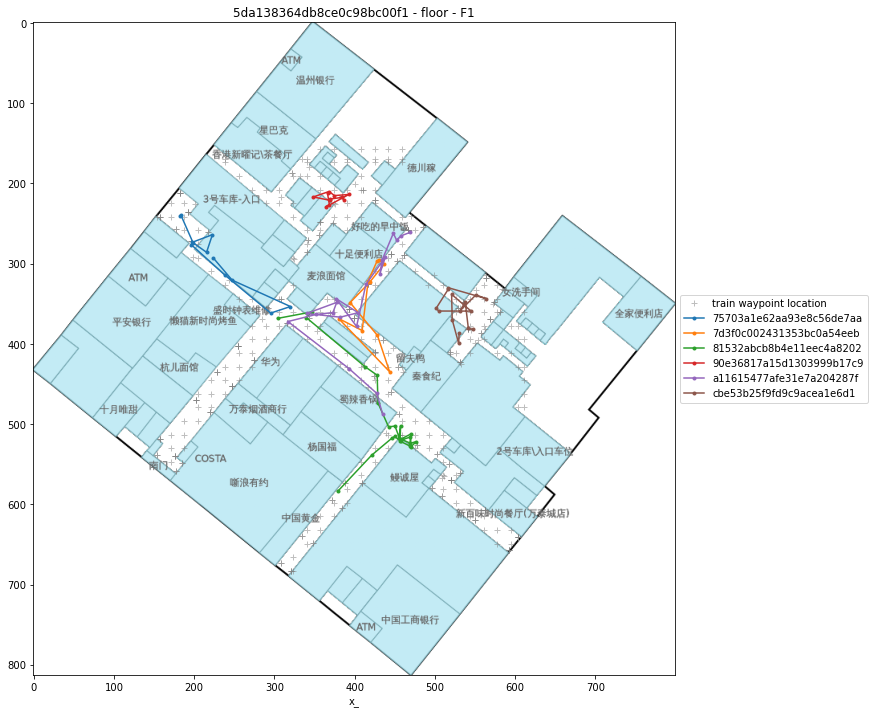

In [ ]:
# Example of raw predictions
plot_preds(example_site, example_floorNo, sub,
           train_waypoints, show_preds=True)
plt.show()

## Step 3: Apply a Threshold and "Snap to Grid"

Let us take the thr = 3

In [ ]:
def snap_to_grid(sub, threshold):
    """
    Snap to grid if within a threshold.
    
    x, y are the predicted points.
    x_, y_ are the closest grid points.
    _x_, _y_ are the new predictions after post processing.
    """
    sub['_x_'] = sub['x']
    sub['_y_'] = sub['y']
    sub.loc[sub['dist'] < threshold, '_x_'] = sub.loc[sub['dist'] < threshold]['x_']
    sub.loc[sub['dist'] < threshold, '_y_'] = sub.loc[sub['dist'] < threshold]['y_']
    return sub.copy()

# Calculate the distances
sub['dist'] = np.sqrt( (sub.x-sub.x_)**2 + (sub.y-sub.y_)**2)

sub_pp = snap_to_grid(sub, threshold=3)

sub_pp = sub_pp[['site_path_timestamp','floor','_x_','_y_','site','path','floorNo']] \
    .rename(columns={'_x_':'x', '_y_':'y'})

Lets take a look at the predictions after post processing.

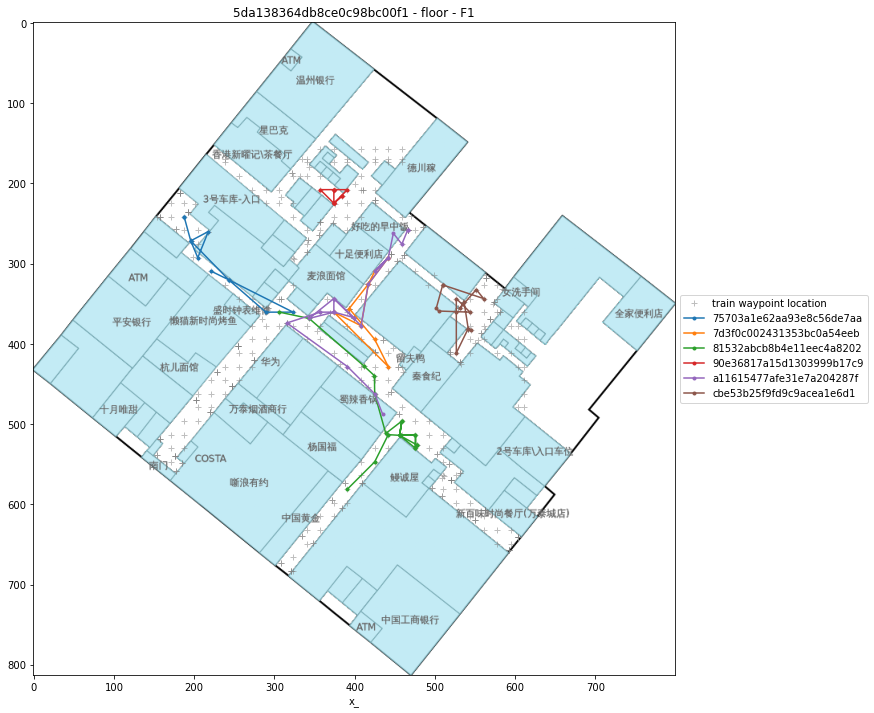

In [ ]:
# Plot example after post processing
plot_preds(example_site, example_floorNo, sub_pp,
           train_waypoints, show_preds=True)
plt.show()

## Evaluate The Change in Predictions

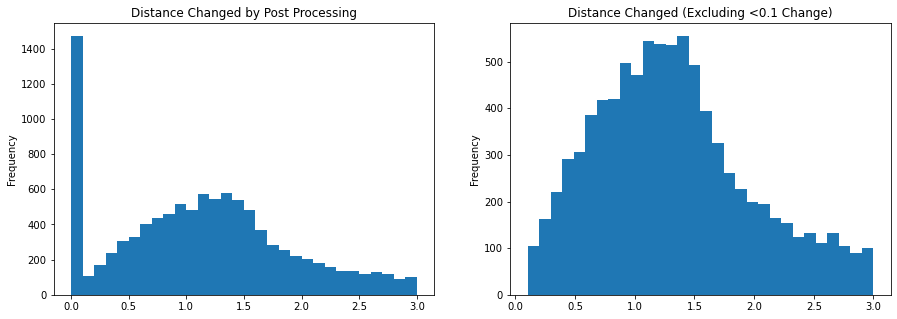

In [ ]:
sub['dist_pp_change'] = np.sqrt(((sub['x'] - sub['_x_']) ** 2) + ((sub['y'] - sub['_y_']) ** 2))
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sub['dist_pp_change'].plot(kind='hist', bins=30,
                           ax=axs[0],
                           title='Distance Changed by Post Processing')
sub.query('dist_pp_change > 0.1')['dist_pp_change'] \
    .plot(kind='hist', bins=30, ax=axs[1],
          title='Distance Changed (Excluding <0.1 Change)')

plt.show()

<AxesSubplot:ylabel='site,floorNo'>

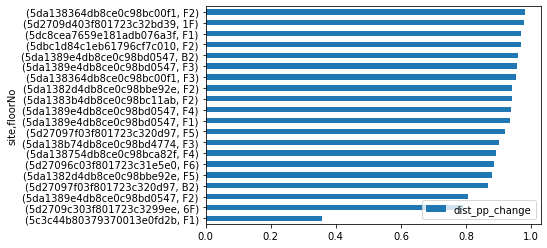

In [ ]:
sub.groupby(['site','floorNo'])['dist_pp_change'].mean() \
    .reset_index() \
    .sort_values('dist_pp_change') \
    .set_index(['site','floorNo']).head(20).plot(kind='barh')

## Final Step: Save Post Processed Submission And New Waypoints.

In [ ]:
sub_pp[['site_path_timestamp','floor','x','y']] \
    .to_csv('submission_snap_to_grid.csv', index=False)

In [ ]:
train_waypoints.to_csv('new_grid.csv')